In [1]:
import collections
import pathlib
from copy import copy

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

%matplotlib inline

sns.set_theme(
    style='whitegrid',
    palette='Set2',
    rc = {
        'figure.figsize': (10, 7.5),
        'legend.loc': 'upper right',
    }
)

sns_kwargs = { 'x': 'nm', 'y': 'Abs' }

In [2]:
def get_dfs(folder):
    split_path = lambda p: str(p).split('\\')[1].split('.')[0].split('_')[1:]
    dfs = collections.defaultdict(dict)
    for path in pathlib.Path(folder).glob('*.csv'):
        mancha, produto = split_path(path)
        dfs[mancha][produto] = pd.read_csv(
            path,
            encoding='utf-16',
            skiprows=9,
            usecols=range(2)
        )
    return dfs

In [8]:
def read_all():
    takes = []
    averaged = collections.defaultdict(dict)

    for i in range(1,4):
        split_path = lambda p: str(p).split('\\')[1].split('.')[0].split('_')[1:]
        dfs = collections.defaultdict(dict)
        manchas = set()
        produtos = set()
        for path in pathlib.Path(f'medida_{i}').glob('*.csv'):
            mancha, produto = split_path(path)
            df = pd.read_csv(path, encoding='utf-16', skiprows=9, usecols=range(2))
            if produto == 'Controle':
                min_abs = df['Abs'].min()
                df['Abs'] = df['Abs'] - min_abs
                averaged[mancha][produto] = df
            else:
                dfs[mancha][produto] = df
                manchas.add(mancha)
                produtos.add(produto)

        takes.append(dfs)

    manchas, produtos = list(manchas), list(produtos)
    for mancha in manchas:
        for produto in produtos:
            df = pd.DataFrame()
            for column in ['nm', 'Abs']:
                to_average = pd.DataFrame()
                for take in takes:
                    column_name = f'{take}-{mancha}-{produto}'
                    to_average[column_name] = take[mancha][produto][column]
                    if column == 'Abs':
                        min_abs = to_average[column_name].min()
                        to_average[column_name] = to_average[column_name] - min_abs
                df[column] = to_average.mean(axis=1)
            averaged[mancha][produto] = df
    
    return averaged

In [4]:
def show_tables(dfs):
    for mancha, value in dfs.items():
        results = pd.DataFrame(columns=['prod', 'auc'])
        base = dfs[mancha]['Controle']
        base_auc = np.trapz(base['Abs'])
        for produto, df in value.items():
            auc = np.trapz(df['Abs'])
            auc = auc / base_auc
            if produto != 'Controle':   
                results.loc[len(results)] = [produto, auc]
        
        results = results.sort_values(by=['auc'])
        results['auc'] = results['auc'].apply(lambda auc: f'{auc:.0%}')
        results = results.rename(columns={
            'prod': 'Produto',
            'auc': 'Área debaixo da curva restante'
        })
        display(Markdown(f'## {mancha}\n' + results.to_markdown(index=False)))

In [5]:
def rename_labels(label):
    renamed_labels = {
        'Controle': 'Sujo',
        'Limao': 'Limão e NaHCO3',
    }

    for old, new in renamed_labels.items():
        label = label.replace(old, new)
    
    return label

In [6]:
def show_graphs(dfs):
    figure, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    for axis, item in zip(axes, dfs.items()):
        mancha, value = item    
        for produto, df in value.items():
            df['Abs'] = df['Abs'] * 100
            sns.lineplot(data=df, x='nm', y='Abs', ax=axis)

        legends = [rename_labels(key) for key in value.keys()]
        
        axis.set_title(mancha)
        axis.set_ylabel('Absorbância')
        axis.set_xlabel('Comprimento de onda (nm)')
        axis.legend(legends)
        axis.set_xlim(df['nm'].min(),df['nm'].max())
        axis.yaxis.set_major_formatter(mtick.PercentFormatter())

## Ketchup
| Produto   | Área debaixo da curva restante   |
|:----------|:---------------------------------|
| H2O2      | 16%                              |
| Vanish    | 17%                              |
| H2O       | 18%                              |
| Limao     | 22%                              |

## Vinho
| Produto   | Área debaixo da curva restante   |
|:----------|:---------------------------------|
| Limao     | 31%                              |
| H2O       | 34%                              |
| Vanish    | 36%                              |
| H2O2      | 43%                              |

## Mostarda
| Produto   | Área debaixo da curva restante   |
|:----------|:---------------------------------|
| Vanish    | 29%                              |
| Limao     | 30%                              |
| H2O       | 33%                              |
| H2O2      | 42%                              |

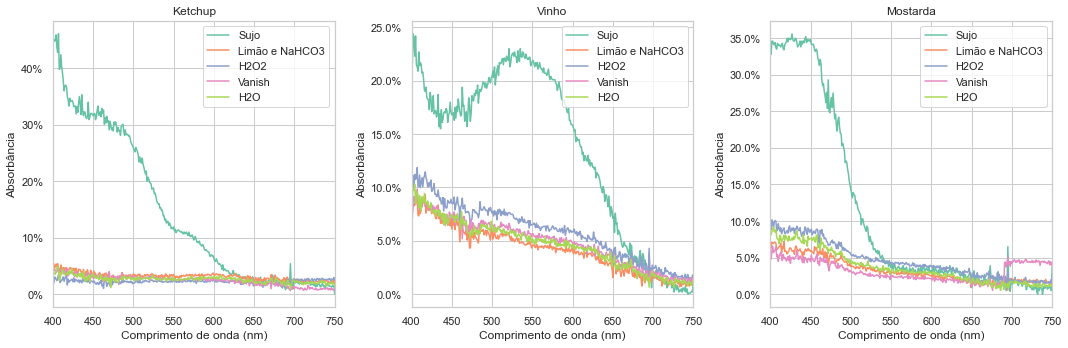

In [9]:
dfs = read_all()
show_graphs(copy(dfs))
show_tables(copy(dfs))